# Weather and Commodities

The goal of this study is to examine the effect of weather on agricultural commodity prices. The initial target is to see how what percentage of price variability is explained by weather, and the secondary target is to predict commodities price movement (directional/classification or actual price). There will be two main datasets used. First is historical price data for corn, cotton, and wheat. This data is a daily closing price for every business day dating back to the 60s. Second is weather data from the National Oceanic and Atmospheric Administration(NOAA). The data set is the global summary of the day (GSOD). This provides data on a number of daily metrics such as temperature, humidity, and wind, for numerous locations across the globe. For this data set, I will only use data from the US, and given the time, only for crop growing regions. Corn, cotton, and wheat are three of the US' biggest crops. This analysis will assume that the US market is the driver of US commodity prices, while it is possible and even probable that imports from other countries would affect prices too.

### Imports

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

% matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Commodities Data

In [3]:
corn = pd.read_csv('./data/corn-price-data.csv', names=['date', 'price'], header=0)
cotton = pd.read_csv('./data/cotton-price-data.csv', names=['date', 'price'], header=0)
wheat = pd.read_csv('./data/wheat-price-data.csv', names=['date', 'price'], header=0)

In [4]:
corn['date'] = pd.to_datetime(corn.date)
cotton['date'] = pd.to_datetime(cotton.date)
wheat['date'] = pd.to_datetime(wheat.date)

In [59]:
print(corn.shape)
print(cotton.shape)
print(wheat.shape)

(12309, 2)
(12310, 2)
(10834, 2)


In [5]:
def recession(x):
    if x > pd.datetime(1975,1,1) and x < pd.datetime(1975,3,31):
        return 1
    if x > pd.datetime(1979,3,31) and x < pd.datetime(1980,6,30):
        return 1
    if x > pd.datetime(1981,3,31) and x < pd.datetime(1982,6,30):
        return 1
    if x > pd.datetime(1989,9,30) and x < pd.datetime(1991,3,31):
        return 1
    if x > pd.datetime(2001,1,1) and x < pd.datetime(2001,9,30):
        return 1
    if x > pd.datetime(2007,9,30) and x < pd.datetime(2009,6,3):
        return 1
    else:
        return 0 

In [6]:
corn['recession'] = corn.date.map(lambda x: recession(x))
cotton['recession'] = cotton.date.map(lambda x: recession(x))
wheat['recession'] = wheat.date.map(lambda x: recession(x))

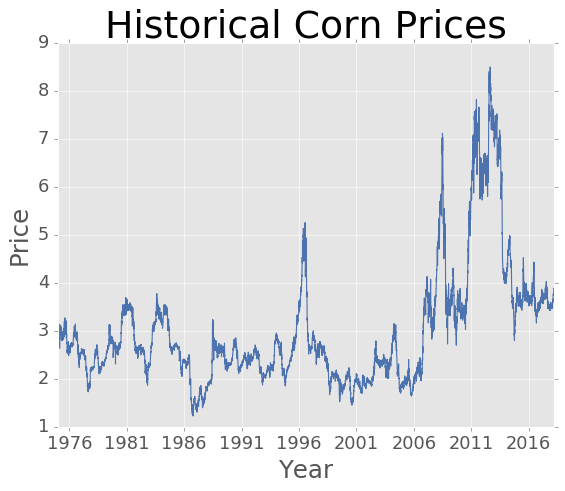

In [416]:
corn = corn[corn.date > pd.datetime(1974,12,31)]
plt.plot(corn.date, corn.price)
plt.title('Historical Corn Prices', fontsize=34)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Price', fontsize=22)
plt.tick_params(labelsize=16);

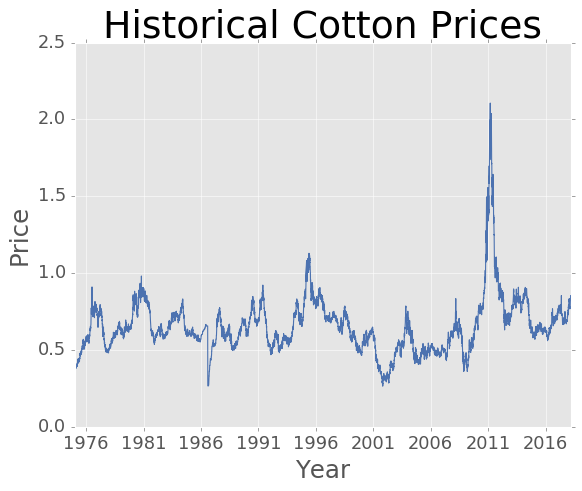

In [417]:
cotton = cotton[cotton.date > pd.datetime(1974,12,31)]
plt.plot(cotton.date, cotton.price)
plt.title('Historical Cotton Prices', fontsize=34)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Price', fontsize=22)
plt.tick_params(labelsize=16);

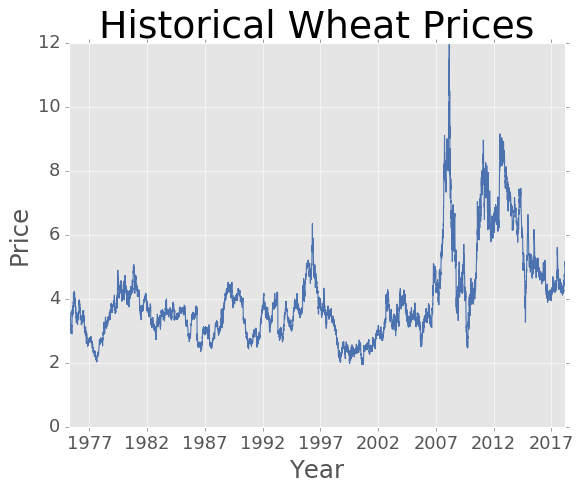

In [418]:
plt.plot(wheat.date, wheat.price)
plt.title('Historical Wheat Prices', fontsize=34)
plt.xlabel('Year', fontsize=22)
plt.ylabel('Price', fontsize=22)
plt.tick_params(labelsize=16);

In [61]:
corn.describe()

,price
count,12309.000000
mean,2.871731
std,1.283200
min,1.025000
25%,2.085000
50%,2.580000
75%,3.395000
max,8.490000


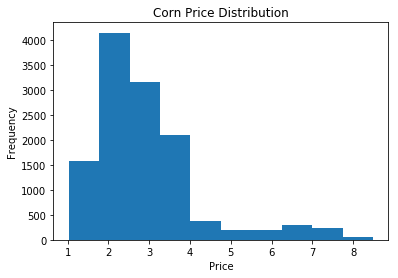

In [9]:
plt.hist(corn['price'])
plt.title('Corn Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');

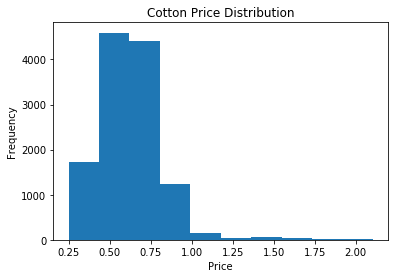

In [10]:
plt.hist(cotton['price'])
plt.title('Cotton Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');

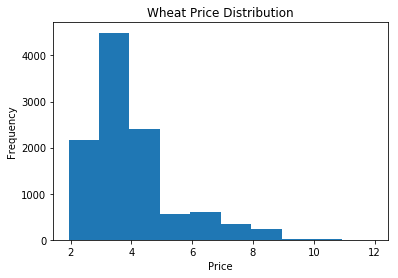

In [11]:
plt.hist(wheat['price'])
plt.title('Wheat Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');

### Weather Data

In [362]:
# turn weather dates into date-time values
def make_date(x):
    x = str(x)
    y = x[:4] + '/' + x[4:6] + '/' + x[6:]
    return pd.to_datetime(y, yearfirst=True)

In [363]:
# station schema, to read in fixed width file
station_schema = pd.read_csv('./data/station_schema.csv')
station_specs = tuple(zip(station_schema.start, station_schema.end))

# read in fixed width station file with schema data
stations = pd.read_fwf('./data/station_ref.txt', colspecs=station_specs)

# filter stations to those in US
us_stations = stations[stations.CT == 'US']
usa_stations = [i for i in us_stations.USAF]

In [364]:
# weather data schema, to read in fixed width file
weather_schema = pd.read_csv('~/desktop/gsod_data/noaa-gsod-data-munging/gsod_schema.csv')

# column names for df
weather_schema.drop([3,4], inplace=True)
weather_schema.loc[2, 'column'] = 'DATE'
weather_schema.loc[0, 'column'] = 'STN'
weather_cols = [i for i in weather_schema.column]

# column widths for df
weather_schema['end'] = weather_schema.start + weather_schema.length
weather_schema.loc[2, 'end'] = 22
weather_specs = tuple(zip(weather_schema.start, weather_schema.end))

In [365]:
def df_specs(years, usa_stations, weather_specs, weather_cols):
    output = {}
    for x in years:
        # read in fixed width weather file with schema specs
        df = pd.read_fwf('~/desktop/gsod_data/data/'+str(x)+'.op', colspecs=weather_specs, header=None, names=weather_cols)
        
        # filter weather data to US stations
        us_weather = df[df.STN.isin(usa_stations)]
        output.update({x:len(us_weather.STN.unique())})
    
    return output

In [366]:
# how many US stations per year
years = [x for x in range(1968, 2019)]
x = df_specs(years, usa_stations, weather_specs, weather_cols)

new_df = pd.DataFrame()
new_df['year'] = x.keys()
new_df['stations'] = x.values()
new_df.to_csv('~/desktop/yearly_stations.csv') # saving for reference
new_df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ccaspar/desktop/gsod_data/data/1968.op'

In [68]:
# filter to US stations and clean data
def save_us_data(years, usa_stations, weather_specs, weather_cols):
    for x in years:
        # read in fixed width weather file with schema specs
        df = pd.read_fwf('~/desktop/gsod_data/data/'+str(x)+'.op', colspecs=weather_specs, header=None, names=weather_cols)

        # drop count and flag columns
        df.drop(['WBAN', 'Count (TEMP)', 'Count (DEWP)', 'Count (SLP)','Count (STP)',
                'Count (VISIB)','Count (WDSP)', 'Flag (MAX)', 'Flag (MIN)',  'Flag (PRCP)'],
                axis=1, inplace=True)
                
        # filter weather data to US stations
        df = df[df.STN.isin(usa_stations)]

        # convert to datetime object
        df.DATE = df.DATE.map(lambda x: make_date(x))

        # replace "9" values with nans in appropriate columns
        nine_thou = ['TEMP', 'DEWP', 'SLP', 'STP', 'MAX', 'MIN']
        nine_hun = ['VISIB', 'WDSP', 'MXSPD', 'GUST', 'SNDP']
        for i in nine_thou:
            df[i].replace(9999.9, np.nan, inplace=True)
        for i in nine_hun:
            df[i].replace(999.9, np.nan, inplace=True)
            df.PRCP.replace(99.99, np.nan, inplace=True)
            
        df.to_csv('~/desktop/gsod_data/data/us_data/'+str(x)+'.csv', index=False)

In [99]:
years = [x for x in range(1975, 2019)]
save_us_data(years, usa_stations, weather_specs, weather_cols)

In [11]:
# list of US stations in each year
stations_list = []
for x in range(1976, 2019):
    df = pd.read_csv('~/desktop/gsod_data/data/us_data/'+str(x)+'.csv')
    stations = [i for i in df.STN.unique()]
    stations_list.append(stations)

# US stations in the year 1975
df = pd.read_csv('~/desktop/gsod_data/data/us_data/1975.csv')
stations_75 = [i for i in df.STN.unique()]

# US stations that are in all years
common_stations = []
for each in stations_75:
    if sum(x.count(each) for x in stations_list) == len(stations_list):
        common_stations.append(each)

In [106]:
# filter to common US stations and impute missing data
def clean_same_stations(years, common_stations):
    for x in years:
        df = pd.read_csv('~/desktop/gsod_data/data/us_data/'+str(x)+'.csv')
        # filter to US stations
        df = df[df.STN.isin(common_stations)]
        
        # reset index
        df.reset_index(inplace=True)
        
        # drop bad variables
        df = df.drop(['STP', 'MXSPD', 'GUST', 'SNDP'], axis=1)

        # separate discrete variables
        disc_vars = df[['PRCP', 'Fog', 'Rain/Drizzle', 'Snow/Ice pellets', 'Hail', 'Thunder','Tornado/Funnel cloud']]

        # interpolate continuous variables
        df = df[['STN', 'DATE','TEMP', 'DEWP', 'SLP', 'VISIB', 'WDSP', 'MAX', 'MIN']]
        df.interpolate(inplace=True)

        # rejoin data
        df = df.join(disc_vars)

        # Mice impute discrete variables
        dates = df['DATE']
        df.drop('DATE', axis=1, inplace = True)
        mice = MICE(verbose=False)
        df = pd.DataFrame(mice.complete(df), columns=[df.columns])
        df = df.join(dates)
        
        df.to_csv('~/desktop/gsod_data/data/us_common_data/'+str(x)+'.csv', index=False)

In [107]:
years = [x for x in range(1975, 2019)]
clean_same_stations(years, common_stations)

In [126]:
df.isnull().sum() / len(df)

STN                     0.0
TEMP                    0.0
DEWP                    0.0
SLP                     0.0
VISIB                   0.0
WDSP                    0.0
MAX                     0.0
MIN                     0.0
PRCP                    0.0
Fog                     0.0
Rain/Drizzle            0.0
Snow/Ice pellets        0.0
Hail                    0.0
Thunder                 0.0
Tornado/Funnel cloud    0.0
DATE                    0.0
dtype: float64

In [55]:
# pivot stations into columns, average weather across stations
years = [x for x in range(1975, 2019)]
cols = ['DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle', 'SLP', 'Snow/Ice pellets','TEMP', 'Thunder', 'Tornado/Funnel cloud', 'VISIB', 'WDSP']
main_df = pd.DataFrame()
for x in years:
    df = pd.read_csv('~/desktop/gsod_data/data/us_common_data/'+str(x)+'.csv')
    piv_df = pd.pivot_table(df, columns= ['STN'], index=['DATE'])
    new_df = pd.DataFrame()
    for i in cols:
        new_df[i] = piv_df[i].mean(axis=1)
    main_df = pd.concat((main_df, new_df))

### Modeling

### Corn

In [7]:
main_df = pd.read_csv('./main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
corn = corn[corn.date > pd.datetime(1974,12,31)]
final_df = pd.merge(corn, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']

In [8]:
main_df.head()

,DATE,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP
0,1975-01-01,26.798754,0.486339,0.000000,44.633060,27.100638,0.096371,0.329690,1020.603498,0.273224,35.227322,0.003643,0.0,13.658761,8.176321
1,1975-01-02,21.699458,0.272242,0.000000,41.133452,24.173132,0.075762,0.179715,1021.942063,0.366548,32.081317,0.014235,0.0,14.337089,8.382384
2,1975-01-03,23.128272,0.329787,0.000000,40.896188,23.129300,0.101460,0.338652,1020.194599,0.349291,32.074468,0.003546,0.0,14.615653,7.834220
3,1975-01-04,24.331663,0.250890,0.001779,42.036744,24.544929,0.097979,0.274021,1018.656830,0.231317,32.974911,0.001779,0.0,14.807192,7.388256
4,1975-01-05,22.518032,0.192446,0.000000,42.088309,22.215063,0.056188,0.089928,1019.560352,0.201439,31.966187,0.000000,0.0,15.439308,7.246763


In [9]:
main_df.columns

Index(['DATE', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud',
       'VISIB', 'WDSP'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


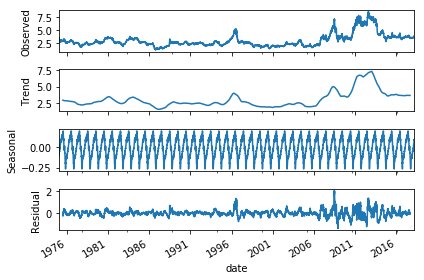

In [6]:
decomposition = seasonal_decompose(final_df.price, freq=252)
decomposition.plot();

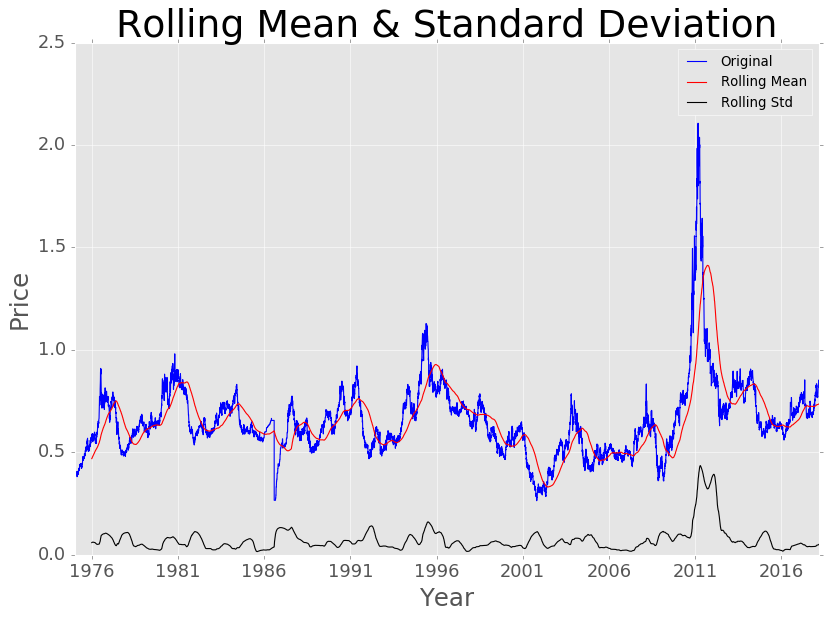

Results of Dickey-Fuller Test:
Test Statistic   -4.398279
p-value           0.000299
dtype: float64


In [419]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=252, center=False).mean()
    rolstd = timeseries.rolling(window=252, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=34)
    plt.xlabel('Year', fontsize=22)
    plt.ylabel('Price', fontsize=22)
    plt.tick_params(labelsize=16);
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput)
    
test_stationarity(final_df.price)

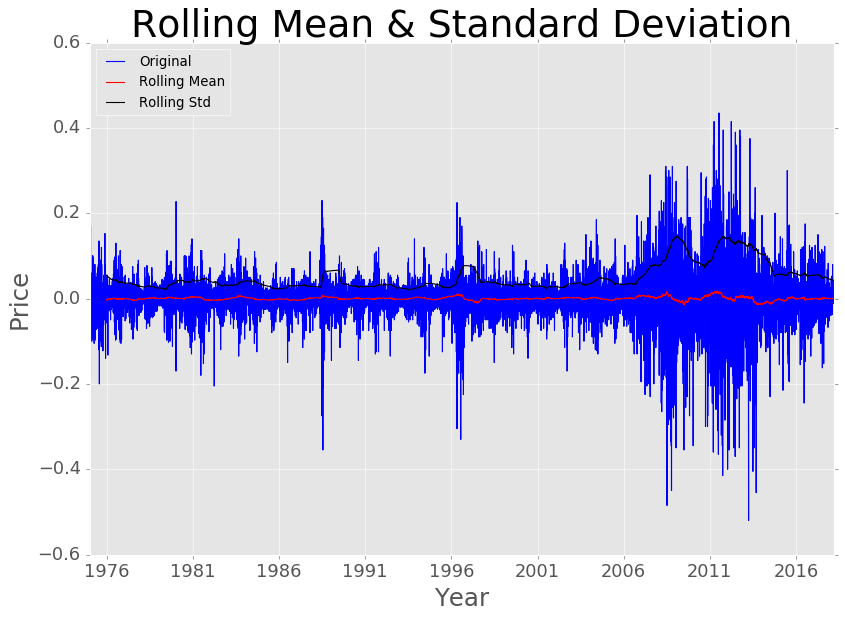

Results of Dickey-Fuller Test:
Test Statistic   -1.469466e+01
p-value           3.011577e-27
dtype: float64


In [422]:
# first difference
final_df['first_diff'] = final_df.price.diff()

# D-F test on first diff column
test_stationarity(final_df.first_diff.dropna())

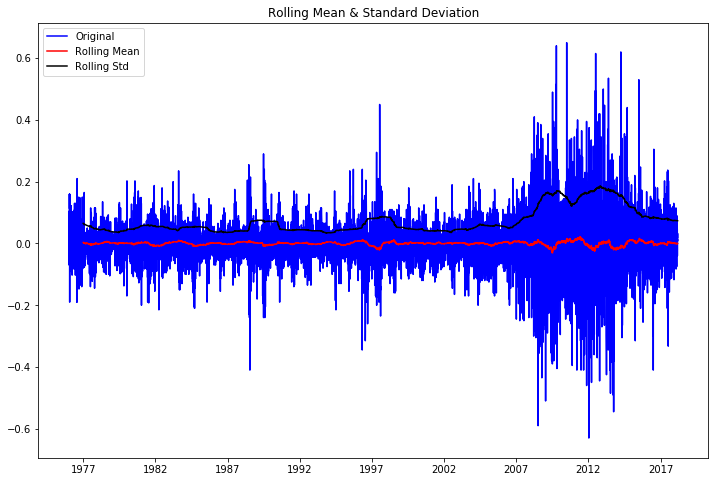

Results of Dickey-Fuller Test:
Test Statistic   -1.451608e+01
p-value           5.622084e-27
dtype: float64


In [9]:
# seasonal + first difference
final_df['seasonal_first_diff'] = final_df.price.diff().diff(252)

# D-F test
test_stationarity(final_df.seasonal_first_diff.dropna())

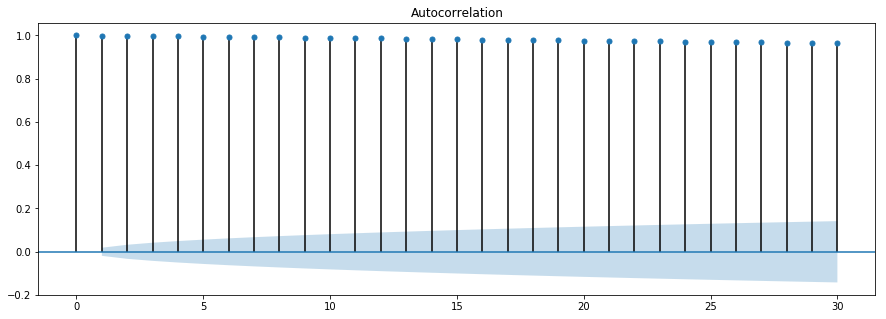

In [76]:
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(final_df.price, lags=30, ax=ax);

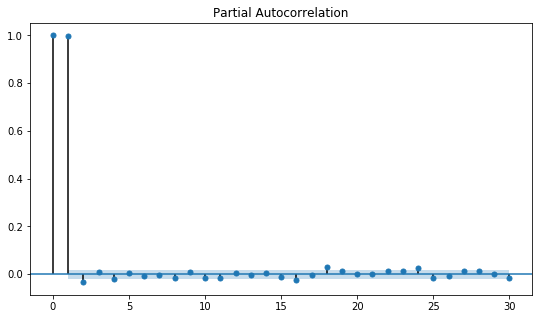

In [31]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(final_df.price, lags=30, ax=ax);

In [423]:
def model_eval(comm, results, final_df):
    # plot residuals
    plt.plot(results.resid[5:])
    plt.title(f'{comm} Price Residuals', fontsize=20)
    plt.xlabel('Year', fontsize=14)
    plt.show()

    # list of 15 day forecasts
    x = 9001      
    forward_15 = []
    for i in range(len(final_df) - 9015):
        pred = results.predict(start=x, end=x+14, dynamic=True)
        forward_15.append(pred[14])
        x += 1

    # 15 day preds vs actual
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(final_df.index[9015:], final_df.price[9015:], lw=2, color='grey', ls='dashed',label='Actual')
    ax.plot(final_df.index[9015:], forward_15, lw=2, color='darkred',label='Pred')
    plt.title(f'{comm} Fifteen Day Predictions vs Actual', fontsize=30)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price', fontsize=18)
    plt.tick_params(labelsize=12);
    plt.legend()
    plt.show()
    
    # 15 day r2 score
    print('15-day forecast r2 score:', r2_score(final_df.price[9015:], forward_15))

In [437]:
# corn model
main_df = pd.read_csv('./main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
corn = corn[corn.date > pd.datetime(1974,12,31)]
final_df = pd.merge(corn, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']


p = 1 # number of lagged values
d = 1 # number of diffs in lag
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days in season

exog = final_df.drop('price', axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10898
Model:               SARIMAX(1, 1, 5)   Log Likelihood               15502.362
Date:                Tue, 10 Apr 2018   AIC                         -30958.724
Time:                        01:07:54   BIC                         -30790.909
Sample:                    01-02-1975   HQIC                        -30902.162
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.013e-13   1.07e-11      0.009      0.992   -2.08e-11     2.1e-11
recession                0.0043      0.017      0.256      0.798      -0.028       0.037
DEWP                    -0.0017      0.001     -2.379      0.017      -0.003      -0.000
Fog                      0.0155      0.016      0.950      0.342      -0.017       0.048
Hail                    -0.0533      0.233     -0.228      0.820      -0.511       0.404
MAX                      0.0002      0.001      0.157      0.875      -0.002       0.002
MIN                      0.0016      0.001      1.449      0.147      -0.001       0.004
PRCP                    -0.0061      0.013     -0.462      0.644      -0.032       0.020
Rain/Drizzle            -0.0073      0.010     -0.708      0.479      -0.027       0.013
SLP                     -0.0002      0.000     -0.658      0.511      -0.001       0.000
Snow/Ice pellets        -0.0122      0.018     -0.679      0.497      -0.047       0.023
TEMP                     0.0002      0.002      0.127      0.899      -0.003       0.004
Thunder                  0.0090      0.016      0.557      0.578      -0.023       0.041
Tornado/Funnel cloud     0.4772      0.483      0.988      0.323      -0.470       1.424
VISIB                   -0.0005      0.002     -0.291      0.771      -0.004       0.003
WDSP                  6.747e-06      0.001      0.009      0.993      -0.002       0.002
ar.L1                   -0.1251      0.716     -0.175      0.861      -1.528       1.277
ma.L1                    0.1625      0.715      0.227      0.820      -1.240       1.564
ma.L2                   -0.0057      0.027     -0.208      0.835      -0.059       0.048
ma.L3                    0.0224      0.009      2.460      0.014       0.005       0.040
ma.L4                   -0.0010      0.018     -0.053      0.957      -0.036       0.034
ma.L5                    0.0066      0.006      1.088      0.276      -0.005       0.019
sigma2                   0.0034   1.93e-05    176.683      0.000       0.003       0.003
===================================================================================
Ljung-Box (Q):                      103.86   Jarque-Bera (JB):             46154.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.08   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+25. Standard errors may be unstable.
"""

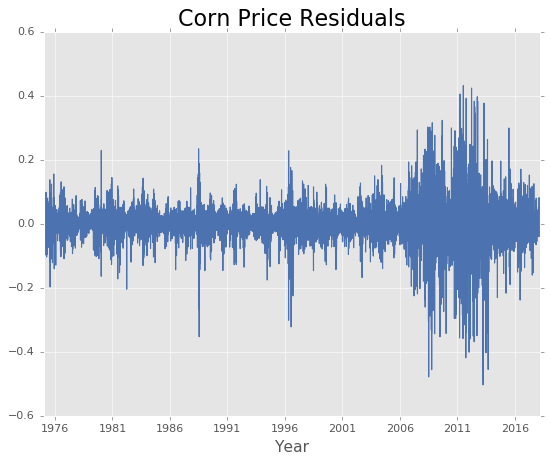

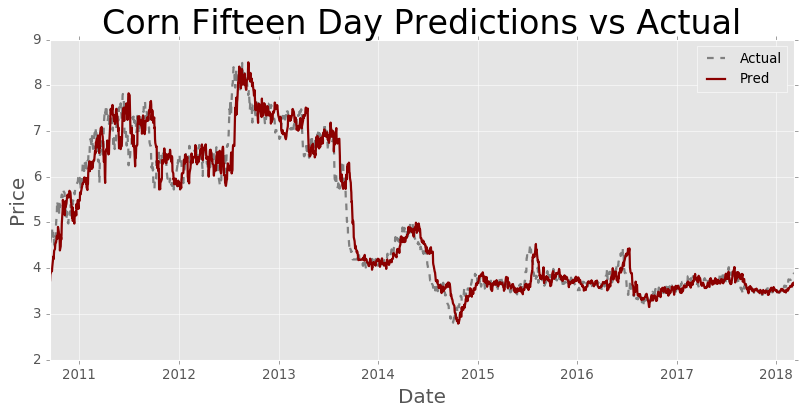

15-day forecast r2 score: 0.9384784440457026


In [425]:
model_eval('Corn', results, final_df)

In [278]:
# function for model profit analysis
# returns dates and corresponding money totals
def profit_loss(dollars, start, forward_15, final_df):
    i = start
    in_market = False
    shares = 0
    money = dollars
    dates= [9000+i]
    tracker = [dollars]
    while i < len(forward_15):
        pred_price = forward_15[i]
        current_price = final_df.price[9000+i]
        if current_price < pred_price and in_market==False:
            entry = current_price
            shares = money / entry
            in_market=True

        if current_price > pred_price and in_market==True:
            exit = current_price
            money = shares * exit
            in_market=False
            dates.append(i+9000)
            tracker.append(money)
        i += 15
    return dates, tracker

In [302]:
# function for model profit analysis
# returns percent gain/loss
def profit_loss_perc(dollars, start, forward_15, final_df):
    i = start
    in_market = False
    shares = 0
    money = dollars
    
    while i < len(forward_15):
        pred_price = forward_15[i]
        current_price = final_df.price[9000+i]
        if current_price < pred_price and in_market==False:
            entry = current_price
            shares = money / entry
            in_market=True

        if current_price > pred_price and in_market==True:
            exit = current_price
            money = shares * exit
            in_market=False
        i += 15
    return (money / dollars) / (current_price / final_df.price[9000+start])

In [438]:
# list of 15 day forecasts
x = 9001      
forward_15 = []
for i in range(len(final_df) - 9015):
    pred = results.predict(start=x, end=x+14, dynamic=True)
    forward_15.append(pred[14])
    x += 1

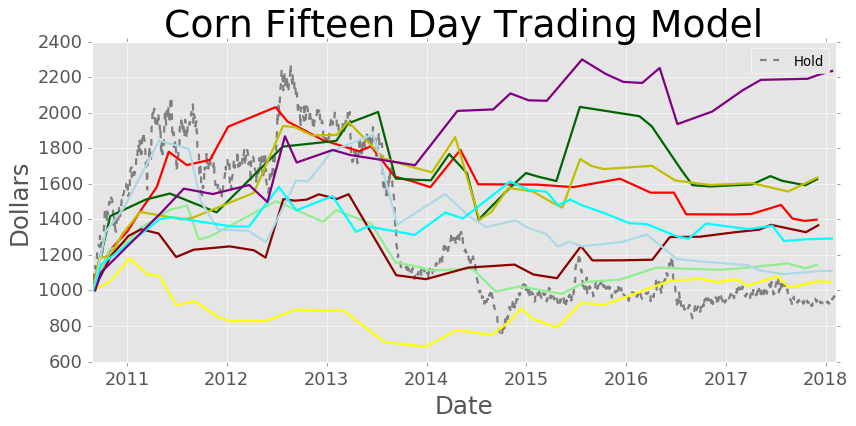

In [439]:
# corn $1000 profit vs. holding
dates, tracker = profit_loss(1000, 0, forward_15, final_df)

color=['r', 'lightgreen', 'darkgreen', 'y', 'darkred', 'yellow', 'lightblue', 'cyan', 'purple', 'orange', 'b', 'indigo', 'violet','gold','darkblue']
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(final_df.index[9000:len(final_df) - 20], final_df.price[9000:len(final_df) - 20]*(1000/final_df.price[9000]), lw=2, color='grey', ls='dashed',label='Hold')
for x in range(9):
    dates, tracker = profit_loss(1000, x, forward_15, final_df)
    ax.plot(final_df.index[dates], tracker, lw=2, c=color[x])
plt.title('Corn Fifteen Day Trading Model', fontsize=34)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Dollars', fontsize=22)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

In [307]:
profit_loss_perc(100, 0, forward_15, final_df)

1.4464693021271176

In [311]:
np.mean([profit_loss_perc(100, n, forward_15, final_df) for n in range(15)])

1.605556466167472

### Cotton

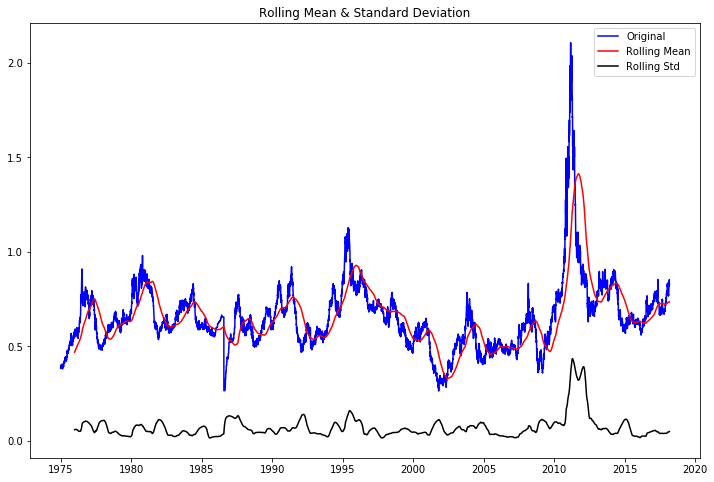

Results of Dickey-Fuller Test:
Test Statistic   -4.398279
p-value           0.000299
dtype: float64


In [32]:
# cotton D-F test
test_stationarity(final_df.price)

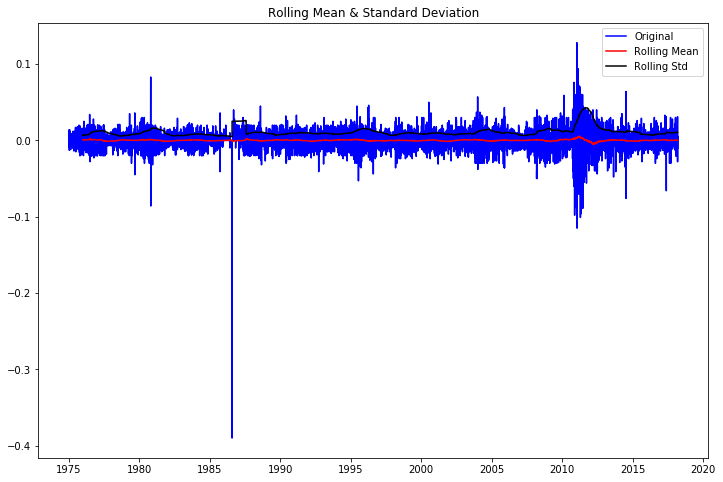

Results of Dickey-Fuller Test:
Test Statistic   -1.432665e+01
p-value           1.117733e-26
dtype: float64


In [33]:
# cotton first difference
final_df['first_diff'] = final_df.price.diff()

# D-F test on first diff column
test_stationarity(final_df.first_diff.dropna())

In [434]:
# cotton model
main_df = pd.read_csv('.//main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
cotton = cotton[cotton.date > pd.datetime(1974,12,31)]
final_df = pd.merge(cotton, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']


p = 1 # lagged values
d = 1 # diffs
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days preceding

exog = final_df.drop('price', axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10899
Model:               SARIMAX(1, 1, 5)   Log Likelihood               32442.099
Date:                Tue, 10 Apr 2018   AIC                         -64838.197
Time:                        01:04:59   BIC                         -64670.380
Sample:                    01-02-1975   HQIC                        -64781.634
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.931e-16   2.29e-12   8.43e-05      1.000   -4.49e-12    4.49e-12
recession               -0.0028      0.003     -0.840      0.401      -0.009       0.004
DEWP                 -7.189e-05      0.000     -0.491      0.623      -0.000       0.000
Fog                      0.0014      0.003      0.417      0.677      -0.005       0.008
Hail                    -0.0071      0.048     -0.148      0.882      -0.101       0.086
MAX                   7.249e-05      0.000      0.368      0.713      -0.000       0.000
MIN                      0.0002      0.000      0.949      0.343      -0.000       0.001
PRCP                    -0.0014      0.003     -0.491      0.623      -0.007       0.004
Rain/Drizzle            -0.0032      0.002     -1.491      0.136      -0.007       0.001
SLP                  -1.076e-05   5.92e-05     -0.182      0.856      -0.000       0.000
Snow/Ice pellets         0.0010      0.003      0.317      0.751      -0.005       0.007
TEMP                    -0.0001      0.000     -0.318      0.750      -0.001       0.001
Thunder                 -0.0030      0.004     -0.804      0.421      -0.010       0.004
Tornado/Funnel cloud    -0.1359      0.123     -1.105      0.269      -0.377       0.105
VISIB                   -0.0001      0.000     -0.433      0.665      -0.001       0.000
WDSP                 -4.407e-05      0.000     -0.256      0.798      -0.000       0.000
ar.L1                   -0.2350      0.234     -1.005      0.315      -0.693       0.223
ma.L1                    0.2800      0.234      1.196      0.232      -0.179       0.739
ma.L2                    0.0124      0.011      1.140      0.254      -0.009       0.034
ma.L3                   -0.0141      0.005     -2.975      0.003      -0.023      -0.005
ma.L4                    0.0092      0.006      1.613      0.107      -0.002       0.020
ma.L5                    0.0227      0.005      4.291      0.000       0.012       0.033
sigma2                   0.0002   3.45e-07    441.397      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      154.54   Jarque-Bera (JB):           4525003.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -3.05
Prob(H) (two-sided):                  0.00   Kurtosis:                       102.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+25. Standard errors may be unstable.
"""

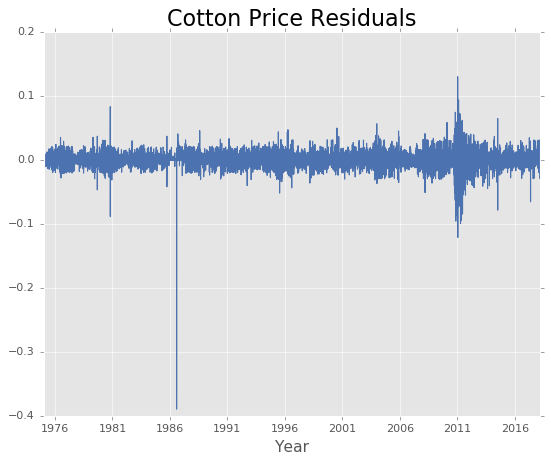

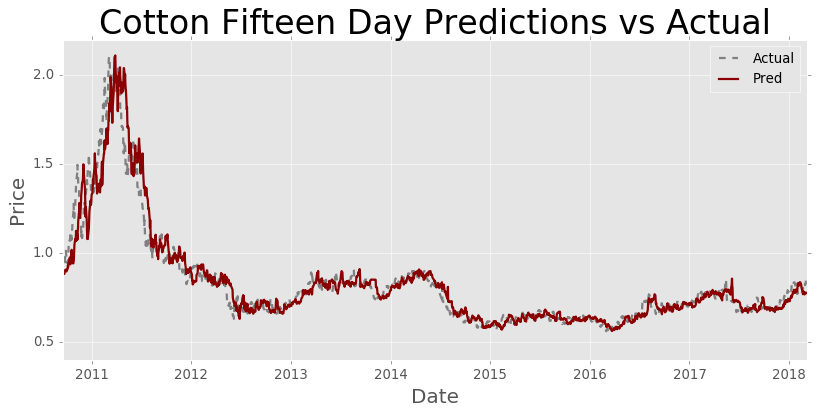

15-day forecast r2 score: 0.9137357202275361


In [427]:
model_eval('Cotton', results, final_df)

In [435]:
# list of 15 day forecasts
x = 9001      
forward_15 = []
for i in range(len(final_df) - 9015):
    pred = results.predict(start=x, end=x+14, dynamic=True)
    forward_15.append(pred[14])
    x += 1

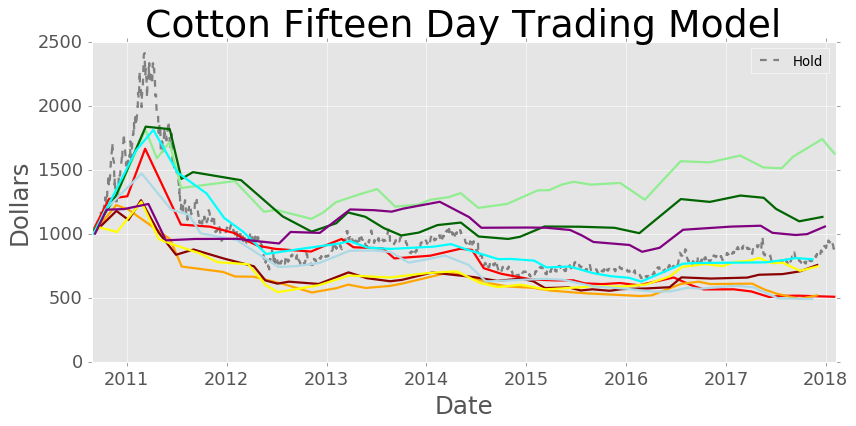

In [436]:
# cotton $1000 profit vs. holding
dates, tracker = profit_loss(1000, 0, forward_15, final_df)

color=['r', 'lightgreen', 'darkgreen', 'orange', 'darkred', 'yellow', 'lightblue', 'cyan', 'purple', 'orange', 'b', 'indigo', 'violet','gold','darkblue']
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(final_df.index[9000:len(final_df) - 20], final_df.price[9000:len(final_df) - 20]*(1000/final_df.price[9000]), lw=2, color='grey', ls='dashed',label='Hold')
for x in range(9):
    dates, tracker = profit_loss(1000, x, forward_15, final_df)
    ax.plot(final_df.index[dates], tracker, lw=2, c=color[x])
plt.title('Cotton Fifteen Day Trading Model', fontsize=34)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Dollars', fontsize=22)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

In [314]:
np.mean([profit_loss_perc(100, n, forward_15, final_df) for n in range(15)])

1.1611932802634404

### Wheat

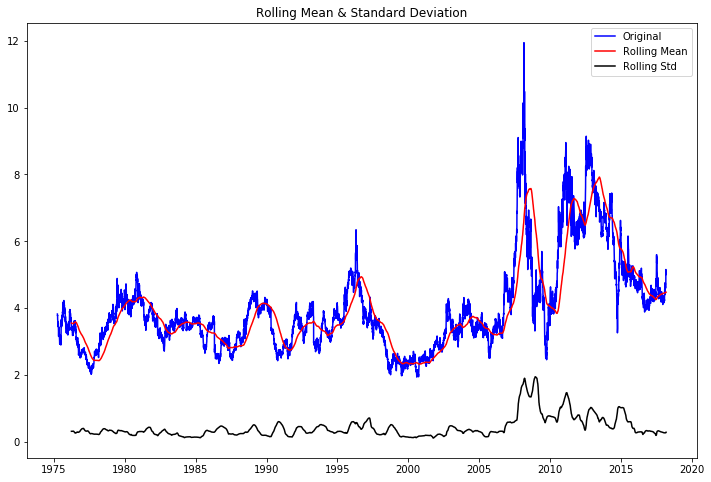

Results of Dickey-Fuller Test:
Test Statistic   -3.061788
p-value           0.029513
dtype: float64


In [20]:
# wheat D-F test
test_stationarity(final_df.price)

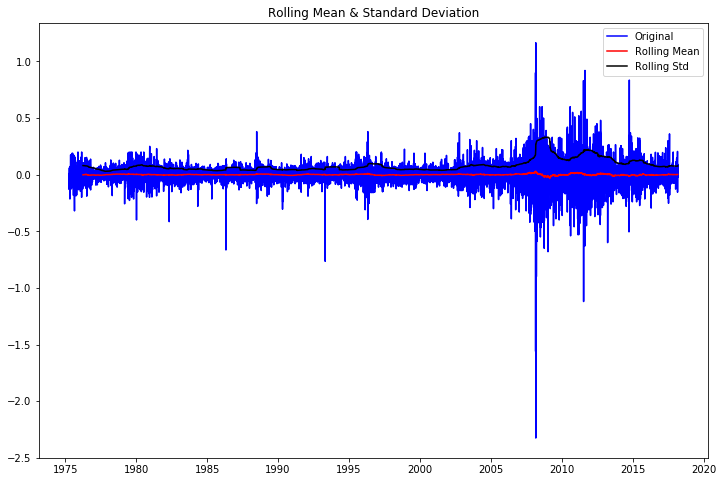

Results of Dickey-Fuller Test:
Test Statistic   -20.761168
p-value            0.000000
dtype: float64


In [21]:
# wheat first difference
final_df['first_diff'] = final_df.price.diff()

# D-F test on first diff column
test_stationarity(final_df.first_diff.dropna())

In [428]:
# wheat model
main_df = pd.read_csv('./main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
final_df = pd.merge(wheat, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']



p = 1 # lagged values
d = 1 # diffs
q = 5 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days preceding

exog = final_df.drop('price', axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10834
Model:               SARIMAX(1, 1, 5)   Log Likelihood                9913.356
Date:                Tue, 10 Apr 2018   AIC                         -19780.711
Time:                        00:51:09   BIC                         -19613.031
Sample:                    04-04-1975   HQIC                        -19724.178
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.797e-12        nan        nan        nan         nan         nan
recession                0.0517      0.019      2.694      0.007       0.014       0.089
DEWP                    -0.0015      0.001     -1.290      0.197      -0.004       0.001
Fog                      0.0305      0.029      1.048      0.295      -0.027       0.087
Hail                     0.0225      0.444      0.051      0.960      -0.848       0.893
MAX                     -0.0008      0.002     -0.418      0.676      -0.004       0.003
MIN                     -0.0010      0.002     -0.501      0.616      -0.005       0.003
PRCP                    -0.0757      0.022     -3.375      0.001      -0.120      -0.032
Rain/Drizzle            -0.0106      0.018     -0.604      0.546      -0.045       0.024
SLP                     -0.0002      0.000     -0.420      0.675      -0.001       0.001
Snow/Ice pellets        -0.0548      0.028     -1.930      0.054      -0.111       0.001
TEMP                     0.0026      0.003      0.830      0.406      -0.004       0.009
Thunder                  0.0226      0.029      0.790      0.429      -0.034       0.079
Tornado/Funnel cloud     0.4136      0.923      0.448      0.654      -1.396       2.223
VISIB                 7.011e-05      0.003      0.023      0.982      -0.006       0.006
WDSP                     0.0026      0.001      1.944      0.052   -2.19e-05       0.005
ar.L1                   -0.7619      0.722     -1.056      0.291      -2.177       0.653
ma.L1                    1.2691      1.325      0.958      0.338      -1.328       3.866
ma.L2                   -0.1147      0.051     -2.244      0.025      -0.215      -0.015
ma.L3                   -0.0395      0.076     -0.520      0.603      -0.189       0.110
ma.L4                   -0.0066      0.038     -0.174      0.862      -0.081       0.068
ma.L5                   -0.0491      0.054     -0.905      0.365      -0.155       0.057
sigma2                   0.0054      0.011      0.508      0.612      -0.015       0.026
===================================================================================
Ljung-Box (Q):                      192.98   Jarque-Bera (JB):            787973.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.45   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.81e+24. Standard errors may be unstable.
"""

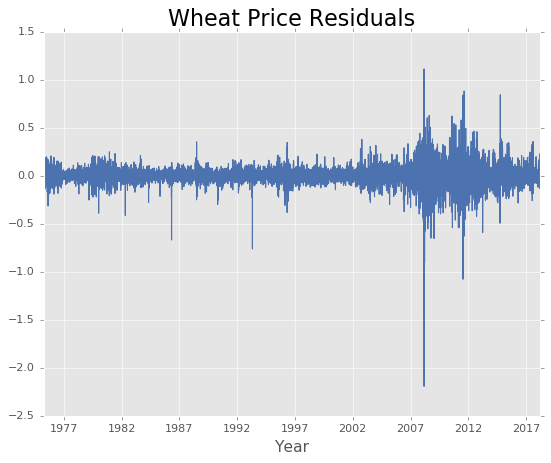

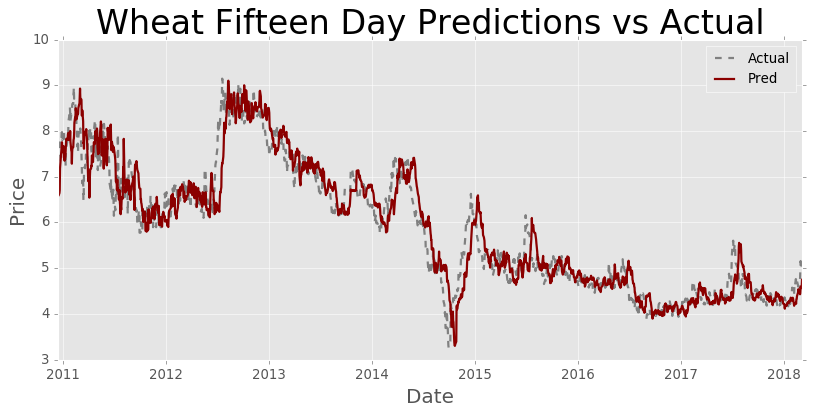

15-day forecast r2 score: 0.8930246611019044


In [429]:
model_eval('Wheat', results, final_df)

In [430]:
# list of 15 day forecasts
x = 9001      
forward_15 = []
for i in range(len(final_df) - 9015):
    pred = results.predict(start=x, end=x+14, dynamic=True)
    forward_15.append(pred[14])
    x += 1

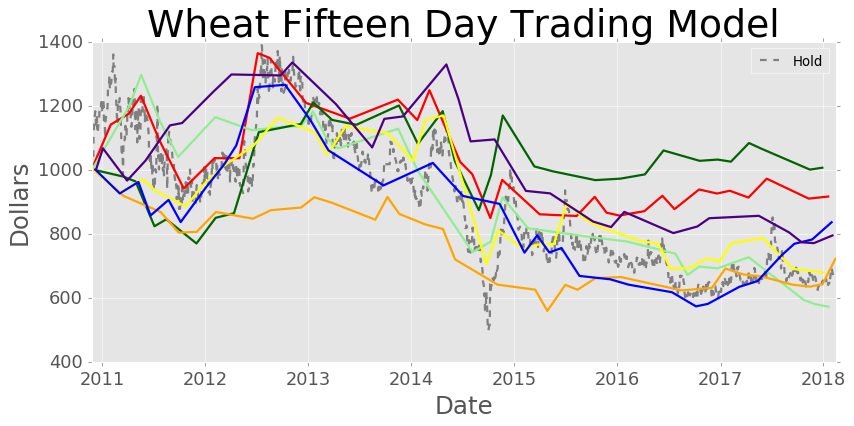

In [432]:
# wheat $1000 profit vs. holding
dates, tracker = profit_loss(1000, 0, forward_15, final_df)
nums = [0,1,2,3,5,8,11]
color=['r', 'lightgreen', 'darkgreen', 'orange', 'darkred', 'yellow', 'lightblue', 'cyan', 'blue', 'orange', 'b', 'indigo', 'violet','gold','darkblue']
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(final_df.index[9000:len(final_df) - 20], final_df.price[9000:len(final_df) - 20]*(1000/final_df.price[9000]), lw=2, color='grey', ls='dashed',label='Hold')
for x in nums:
    dates, tracker = profit_loss(1000, x, forward_15, final_df)
    ax.plot(final_df.index[dates], tracker, lw=2, c=color[x])
plt.title('Wheat Fifteen Day Trading Model', fontsize=34)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Dollars', fontsize=22)
plt.tick_params(labelsize=16)
plt.legend()
plt.show()

In [317]:
np.mean([profit_loss_perc(100, n, forward_15, final_df) for n in range(15)])

1.2618396355666124

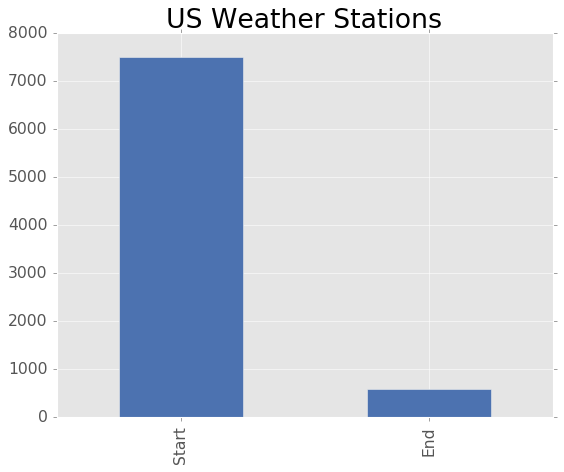

In [397]:
plt.style.use("seaborn-deep")

df = pd.DataFrame({'time': ['Start', 'End'],'num': [7514, 588]})

df.plot(kind='bar', x='time', y='num', legend=False)
plt.title('US Weather Stations', fontsize=24)
plt.xlabel('')
plt.tick_params(labelsize=14);

In [181]:
stat_co = [x for x in df.STN.value_counts()]

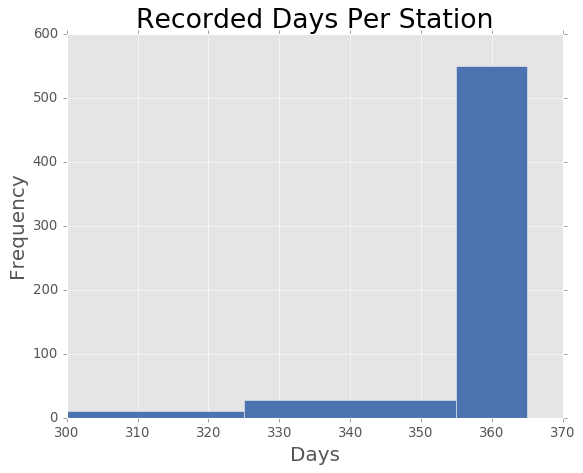

In [410]:
# how many days of data does each station have
x = []
for i in range(10):
    x.append(310)
for i in range(28):
    x.append(340)
for i in range(550):
    x.append(360)

plt.hist(x, bins=[300,325,355,365])
plt.title('Recorded Days Per Station', fontsize=24)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(labelsize=12);